In [1]:
# Atelier interactif : Krigeage Simple (Simple Kriging)

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import ipywidgets as widgets
from IPython.display import display

# -----------------------------
# 1. Génération de données synthétiques
# -----------------------------
np.random.seed(42)

# Création d'une grille 1D
x_grid = np.linspace(0, 100, 200)

# Points d'échantillonnage
x_samples = np.array([10, 25, 40, 60, 75, 90])
y_samples = np.sin(x_samples * 0.1) + np.random.normal(0, 0.1, len(x_samples))

# -----------------------------
# 2. Définir un variogramme exponentiel
# -----------------------------
def exponential_cov(h, range_, sill):
    return sill * np.exp(-h / range_)

# -----------------------------
# 3. Fonction de krigeage simple
# -----------------------------
def simple_kriging(x_grid, x_samples, y_samples, range_, sill, mean):
    # Distances
    d_grid_samples = cdist(x_grid[:, None], x_samples[:, None])
    d_samples = cdist(x_samples[:, None], x_samples[:, None])

    # Matrices de covariance
    C = exponential_cov(d_samples, range_, sill)
    c0 = exponential_cov(d_grid_samples, range_, sill)

    # Résolution du système : poids = C^-1 * c0.T
    weights = np.linalg.solve(C, c0.T)

    # Estimateur : somme des poids * y_samples
    y_est = mean + weights.T @ (y_samples - mean)

    # Variance du krigeage
    sigma2 = sill - np.sum(weights * c0.T, axis=0)

    return y_est, sigma2

# -----------------------------
# 4. Widget interactif
# -----------------------------
range_slider = widgets.FloatSlider(value=15, min=1, max=50, step=1, description='Portée')
sill_slider = widgets.FloatSlider(value=1, min=0.1, max=2, step=0.1, description='Sill')
mean_slider = widgets.FloatSlider(value=0, min=-1, max=1, step=0.1, description='Moyenne')


def update_kriging(range_, sill, mean):
    y_est, sigma2 = simple_kriging(x_grid, x_samples, y_samples, range_, sill, mean)

    plt.figure(figsize=(10, 5))
    plt.plot(x_grid, y_est, label='Estimation krigeage', color='red')
    plt.fill_between(x_grid, y_est - np.sqrt(sigma2), y_est + np.sqrt(sigma2),
                     color='red', alpha=0.2, label='Incertitude (σ)')
    plt.scatter(x_samples, y_samples, color='black', label='Données')
    plt.title('Krigeage Simple 1D')
    plt.xlabel('Position')
    plt.ylabel('Valeur')
    plt.legend()
    plt.grid(True)
    plt.show()

widgets.interact(update_kriging, range_=range_slider, sill=sill_slider, mean=mean_slider);

interactive(children=(FloatSlider(value=15.0, description='Portée', max=50.0, min=1.0, step=1.0), FloatSlider(…

Krigeage Ordinaire

In [2]:
# Atelier interactif : Krigeage Ordinaire 2D

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import ipywidgets as widgets
from IPython.display import display

# -----------------------------
# 1. Génération de données synthétiques 2D
# -----------------------------
np.random.seed(0)

# Grille d'estimation
xv, yv = np.meshgrid(np.linspace(0, 100, 50), np.linspace(0, 100, 50))
x_grid = xv.ravel()
y_grid = yv.ravel()

# Points d'échantillonnage (10 points aléatoires)
n_samples = 10
x_samples = np.random.uniform(0, 100, n_samples)
y_samples = np.random.uniform(0, 100, n_samples)

# Valeurs simulées selon une fonction (avec bruit)
z_samples = np.sin(x_samples * 0.05) + np.cos(y_samples * 0.05) + np.random.normal(0, 0.1, n_samples)

# -----------------------------
# 2. Variogramme exponentiel
# -----------------------------
def exponential_cov(h, range_, sill):
    return sill * np.exp(-h / range_)

# -----------------------------
# 3. Krigeage Ordinaire 2D avec voisinage fixe
# -----------------------------
def ordinary_kriging_2d(x_grid, y_grid, x_samples, y_samples, z_samples, range_, sill, n_neighbors=6):
    est = np.zeros_like(x_grid)
    var = np.zeros_like(x_grid)

    for i in range(len(x_grid)):
        x0, y0 = x_grid[i], y_grid[i]
        dists = np.sqrt((x_samples - x0)**2 + (y_samples - y0)**2)
        idx = np.argsort(dists)[:n_neighbors]

        X_neigh = np.vstack((x_samples[idx], y_samples[idx])).T
        Z_neigh = z_samples[idx]
        d_matrix = cdist(X_neigh, X_neigh)
        d_vector = np.sqrt((X_neigh[:,0] - x0)**2 + (X_neigh[:,1] - y0)**2)

        C = exponential_cov(d_matrix, range_, sill)
        c0 = exponential_cov(d_vector, range_, sill)

        # Ajouter contrainte Lagrange (somme des poids = 1)
        C_ext = np.ones((n_neighbors+1, n_neighbors+1))
        C_ext[:n_neighbors, :n_neighbors] = C
        C_ext[-1, -1] = 0

        c0_ext = np.ones(n_neighbors+1)
        c0_ext[:n_neighbors] = c0

        try:
            weights = np.linalg.solve(C_ext, c0_ext)
            est[i] = np.sum(weights[:n_neighbors] * Z_neigh)
            var[i] = sill - np.dot(weights[:n_neighbors], c0)
        except np.linalg.LinAlgError:
            est[i] = np.nan
            var[i] = np.nan

    return est, var

# -----------------------------
# 4. Widgets interactifs
# -----------------------------
range_slider = widgets.FloatSlider(value=20, min=1, max=50, step=1, description='Portée')
sill_slider = widgets.FloatSlider(value=1.0, min=0.1, max=2.0, step=0.1, description='Sill')


def update_kriging_2d(range_, sill):
    est, var = ordinary_kriging_2d(x_grid, y_grid, x_samples, y_samples, z_samples, range_, sill)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    im0 = ax[0].tricontourf(x_grid, y_grid, est, levels=20, cmap='viridis')
    ax[0].scatter(x_samples, y_samples, c='r', edgecolor='k', label='Données')
    ax[0].set_title('Estimation par Krigeage Ordinaire')
    fig.colorbar(im0, ax=ax[0])

    im1 = ax[1].tricontourf(x_grid, y_grid, var, levels=20, cmap='magma')
    ax[1].scatter(x_samples, y_samples, c='r', edgecolor='k')
    ax[1].set_title('Variance du Krigeage')
    fig.colorbar(im1, ax=ax[1])

    for a in ax:
        a.set_xlim(0, 100)
        a.set_ylim(0, 100)
        a.set_aspect('equal')
        a.grid(True)

    plt.tight_layout()
    plt.show()

widgets.interact(update_kriging_2d, range_=range_slider, sill=sill_slider);


interactive(children=(FloatSlider(value=20.0, description='Portée', max=50.0, min=1.0, step=1.0), FloatSlider(…

Voissinage local

In [3]:
# Atelier interactif : Voisinage local 2D avec anisotropie et quadrants

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib.patches import Ellipse

np.random.seed(42)

# -----------------------------
# 1. Données aléatoires 2D
# -----------------------------
n_points = 50
x_data = np.random.uniform(0, 100, n_points)
y_data = np.random.uniform(0, 100, n_points)

# Point cible à estimer
x0, y0 = 50, 50

# -----------------------------
# 2. Fonction pour déterminer les voisins
# -----------------------------
def find_neighbors(x_data, y_data, x0, y0, azimut, anis_ratio, radius, max_per_quad):
    coords = np.vstack((x_data, y_data)).T
    center = np.array([x0, y0])
    
    # Translation
    shifted = coords - center

    # Rotation pour aligner l'ellipse sur l'axe x
    theta = -np.radians(azimut)
    rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta),  np.cos(theta)]])
    rotated = shifted @ rot_matrix.T

    # Appliquer anisotropie (ellipse : x / a, y / b)
    scaled = rotated / np.array([radius, radius / anis_ratio])
    distances = np.linalg.norm(scaled, axis=1)

    # Sélection initiale dans l'ellipse
    in_ellipse = distances <= 1.0
    selected_idx = np.where(in_ellipse)[0]

    # Application des contraintes par quadrant
    final_idx = []
    quadrant_counts = [0, 0, 0, 0]  # Q1 à Q4

    for idx in selected_idx:
        dx = x_data[idx] - x0
        dy = y_data[idx] - y0
        if dx >= 0 and dy >= 0:
            q = 0  # Q1
        elif dx < 0 and dy >= 0:
            q = 1  # Q2
        elif dx < 0 and dy < 0:
            q = 2  # Q3
        else:
            q = 3  # Q4

        if quadrant_counts[q] < max_per_quad:
            final_idx.append(idx)
            quadrant_counts[q] += 1

    return final_idx

# -----------------------------
# 3. Fonction de visualisation
# -----------------------------
def plot_neighbors(azimut, anis_ratio, radius, max_per_quad):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(x_data, y_data, label='Tous les points', color='gray')
    ax.scatter(x0, y0, color='red', label='Point cible')

    idx_sel = find_neighbors(x_data, y_data, x0, y0, azimut, anis_ratio, radius, max_per_quad)
    ax.scatter(x_data[idx_sel], y_data[idx_sel], color='blue', label='Voisins retenus')

    # Dessin de l’ellipse anisotrope
    ellipse = Ellipse((x0, y0), width=2*radius, height=2*radius/anis_ratio,
                      angle=azimut, edgecolor='green', facecolor='none', linestyle='--', linewidth=2)
    ax.add_patch(ellipse)

    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_title("Voisinage local avec ellipse anisotrope et quadrants")
    ax.set_aspect('equal')
    ax.grid(True)
    ax.legend()
    plt.show()

# -----------------------------
# 4. Widgets interactifs
# -----------------------------
azimuth_slider = widgets.IntSlider(value=0, min=0, max=180, step=5, description="Azimut (°)")
anis_slider = widgets.FloatSlider(value=2.0, min=0.5, max=5.0, step=0.1, description="Rapport a/b")
radius_slider = widgets.FloatSlider(value=30, min=5, max=80, step=1, description="Rayon")
quad_slider = widgets.IntSlider(value=2, min=0, max=5, step=1, description="Max/Quadrant")

widgets.interact(plot_neighbors, azimut=azimuth_slider, anis_ratio=anis_slider,
                 radius=radius_slider, max_per_quad=quad_slider);


interactive(children=(IntSlider(value=0, description='Azimut (°)', max=180, step=5), FloatSlider(value=2.0, de…

Effet de pépite

In [4]:
# Atelier 4 : Effet de la épépite (nugget effect) sur le krigeage simple vs ordinaire en 2D

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import ipywidgets as widgets
from matplotlib.colors import Normalize

np.random.seed(0)

# -----------------------------
# 1. Génération de données synthétiques 2D
# -----------------------------
xv, yv = np.meshgrid(np.linspace(0, 100, 50), np.linspace(0, 100, 50))
x_grid = xv.ravel()
y_grid = yv.ravel()

n_samples = 12
x_samples = np.random.uniform(0, 100, n_samples)
y_samples = np.random.uniform(0, 100, n_samples)
z_samples = np.sin(x_samples * 0.05) + np.cos(y_samples * 0.05) + np.random.normal(0, 0.1, n_samples)

# -----------------------------
# 2. Variogramme exponentiel avec effet de épépite
# -----------------------------
def exponential_cov(h, range_, sill, nugget):
    return nugget * (h == 0) + (sill - nugget) * np.exp(-h / range_)

# -----------------------------
# 3. Krigeage simple et ordinaire 2D avec voisinage fixe
# -----------------------------
def kriging_2d(x_grid, y_grid, x_samples, y_samples, z_samples, range_, sill, nugget, kind="simple", mean_global=0.0, n_neighbors=6):
    est = np.zeros_like(x_grid)
    for i in range(len(x_grid)):
        x0, y0 = x_grid[i], y_grid[i]
        dists = np.sqrt((x_samples - x0)**2 + (y_samples - y0)**2)
        idx = np.argsort(dists)[:n_neighbors]

        X_neigh = np.vstack((x_samples[idx], y_samples[idx])).T
        Z_neigh = z_samples[idx]

        d_matrix = cdist(X_neigh, X_neigh)
        d_vector = np.sqrt((X_neigh[:,0] - x0)**2 + (X_neigh[:,1] - y0)**2)

        C = exponential_cov(d_matrix, range_, sill, nugget)
        c0 = exponential_cov(d_vector, range_, sill, nugget)

        if kind == "simple":
            try:
                weights = np.linalg.solve(C, c0)
                est[i] = mean_global + weights @ (Z_neigh - mean_global)
            except np.linalg.LinAlgError:
                est[i] = np.nan
        elif kind == "ordinary":
            C_ext = np.ones((n_neighbors+1, n_neighbors+1))
            C_ext[:n_neighbors, :n_neighbors] = C
            C_ext[-1, -1] = 0
            c0_ext = np.ones(n_neighbors+1)
            c0_ext[:n_neighbors] = c0
            try:
                weights = np.linalg.solve(C_ext, c0_ext)
                est[i] = np.sum(weights[:n_neighbors] * Z_neigh)
            except np.linalg.LinAlgError:
                est[i] = np.nan

    return est

# -----------------------------
# 4. Interface interactive
# -----------------------------
range_slider = widgets.FloatSlider(value=20, min=5, max=50, step=1, description='Portée')
sill_slider = widgets.FloatSlider(value=1.0, min=0.2, max=2.0, step=0.1, description='Sill')
nugget_slider = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description='Épépite')


def update_kriging(range_, sill, nugget):
    est_simple = kriging_2d(x_grid, y_grid, x_samples, y_samples, z_samples,
                            range_, sill, nugget, kind="simple", mean_global=np.mean(z_samples))
    est_ordinary = kriging_2d(x_grid, y_grid, x_samples, y_samples, z_samples,
                              range_, sill, nugget, kind="ordinary")

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    norm = Normalize(vmin=min(np.min(est_simple), np.min(est_ordinary)), vmax=max(np.max(est_simple), np.max(est_ordinary)))

    im0 = ax[0].tricontourf(x_grid, y_grid, est_ordinary, levels=20, cmap='viridis', norm=norm)
    ax[0].scatter(x_samples, y_samples, color='red', edgecolor='k')
    ax[0].set_title("Krigeage Ordinaire")
    fig.colorbar(im0, ax=ax[0])

    im1 = ax[1].tricontourf(x_grid, y_grid, est_simple, levels=20, cmap='viridis', norm=norm)
    ax[1].scatter(x_samples, y_samples, color='red', edgecolor='k')
    ax[1].set_title("Krigeage Simple")
    fig.colorbar(im1, ax=ax[1])

    for a in ax:
        a.set_xlim(0, 100)
        a.set_ylim(0, 100)
        a.set_aspect('equal')
        a.grid(True)

    plt.tight_layout()
    plt.show()

widgets.interact(update_kriging, range_=range_slider, sill=sill_slider, nugget=nugget_slider);


interactive(children=(FloatSlider(value=20.0, description='Portée', max=50.0, min=5.0, step=1.0), FloatSlider(…

Effet d'écran

In [5]:
# Atelier : Effet d'écran en krigeage (shadowing effect)

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import ipywidgets as widgets
from matplotlib.patches import Circle

np.random.seed(1)

# -----------------------------
# 1. Données avec positions fixes
# -----------------------------
x_samples = np.array([30, 45, 50, 55, 70])
y_samples = np.array([50, 50, 50, 50, 50])
z_samples = np.array([1.0, 2.0, 2.5, 2.0, 1.0])
labels = ["A", "B", "C", "D", "E"]

# -----------------------------
# 2. Covariance exponentielle
# -----------------------------
def exponential_cov(h, range_, sill, nugget=0):
    return nugget * (h == 0) + (sill - nugget) * np.exp(-h / range_)

# -----------------------------
# 3. Krigeage ordinaire avec visualisation des poids
# -----------------------------
def compute_weights(x0, y0, range_, sill):
    X = np.vstack((x_samples, y_samples)).T
    target = np.array([[x0, y0]])

    d_matrix = cdist(X, X)
    d_vector = cdist(X, target).flatten()

    C = exponential_cov(d_matrix, range_, sill)
    c0 = exponential_cov(d_vector, range_, sill)

    # Extension pour krigeage ordinaire (somme des poids = 1)
    n = len(x_samples)
    C_ext = np.ones((n+1, n+1))
    C_ext[:n, :n] = C
    C_ext[-1, -1] = 0
    c0_ext = np.ones(n+1)
    c0_ext[:n] = c0

    try:
        weights = np.linalg.solve(C_ext, c0_ext)
        return weights[:-1]  # sans le lagrange
    except np.linalg.LinAlgError:
        return np.full(n, np.nan)

# -----------------------------
# 4. Affichage interactif avec contrôle de la localisation
# -----------------------------
def plot_shadowing(x0, y0, range_, sill):
    weights = compute_weights(x0, y0, range_, sill)

    fig, ax = plt.subplots(figsize=(8,6))
    sc = ax.scatter(x_samples, y_samples, c=weights, s=200, cmap="coolwarm", edgecolor='k')
    for i, txt in enumerate(labels):
        ax.annotate(f"{txt}\n{weights[i]:.2f}", (x_samples[i]+1, y_samples[i]+2), fontsize=10)

    ax.scatter(x0, y0, c='black', marker='x', s=100, label='Point à estimer')
    ax.add_patch(Circle((x0, y0), radius=20, color='gray', fill=False, linestyle='--'))

    ax.set_xlim(20, 80)
    ax.set_ylim(40, 70)
    ax.set_aspect('equal')
    ax.set_title("Effet d'écran en krigeage : visualisation des poids")
    ax.legend()
    fig.colorbar(sc, ax=ax, label="Poids attribué")
    plt.grid(True)
    plt.show()

# -----------------------------
# 5. Widgets interactifs
# -----------------------------
x0_slider = widgets.FloatSlider(value=50, min=20, max=80, step=1, description='X cible')
y0_slider = widgets.FloatSlider(value=60, min=40, max=70, step=1, description='Y cible')
range_slider = widgets.FloatSlider(value=15, min=5, max=40, step=1, description='Portée')
sill_slider = widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.1, description='Sill')

widgets.interact(plot_shadowing, x0=x0_slider, y0=y0_slider, range_=range_slider, sill=sill_slider);


interactive(children=(FloatSlider(value=50.0, description='X cible', max=80.0, min=20.0, step=1.0), FloatSlide…

Visualisation 1DD krigeage


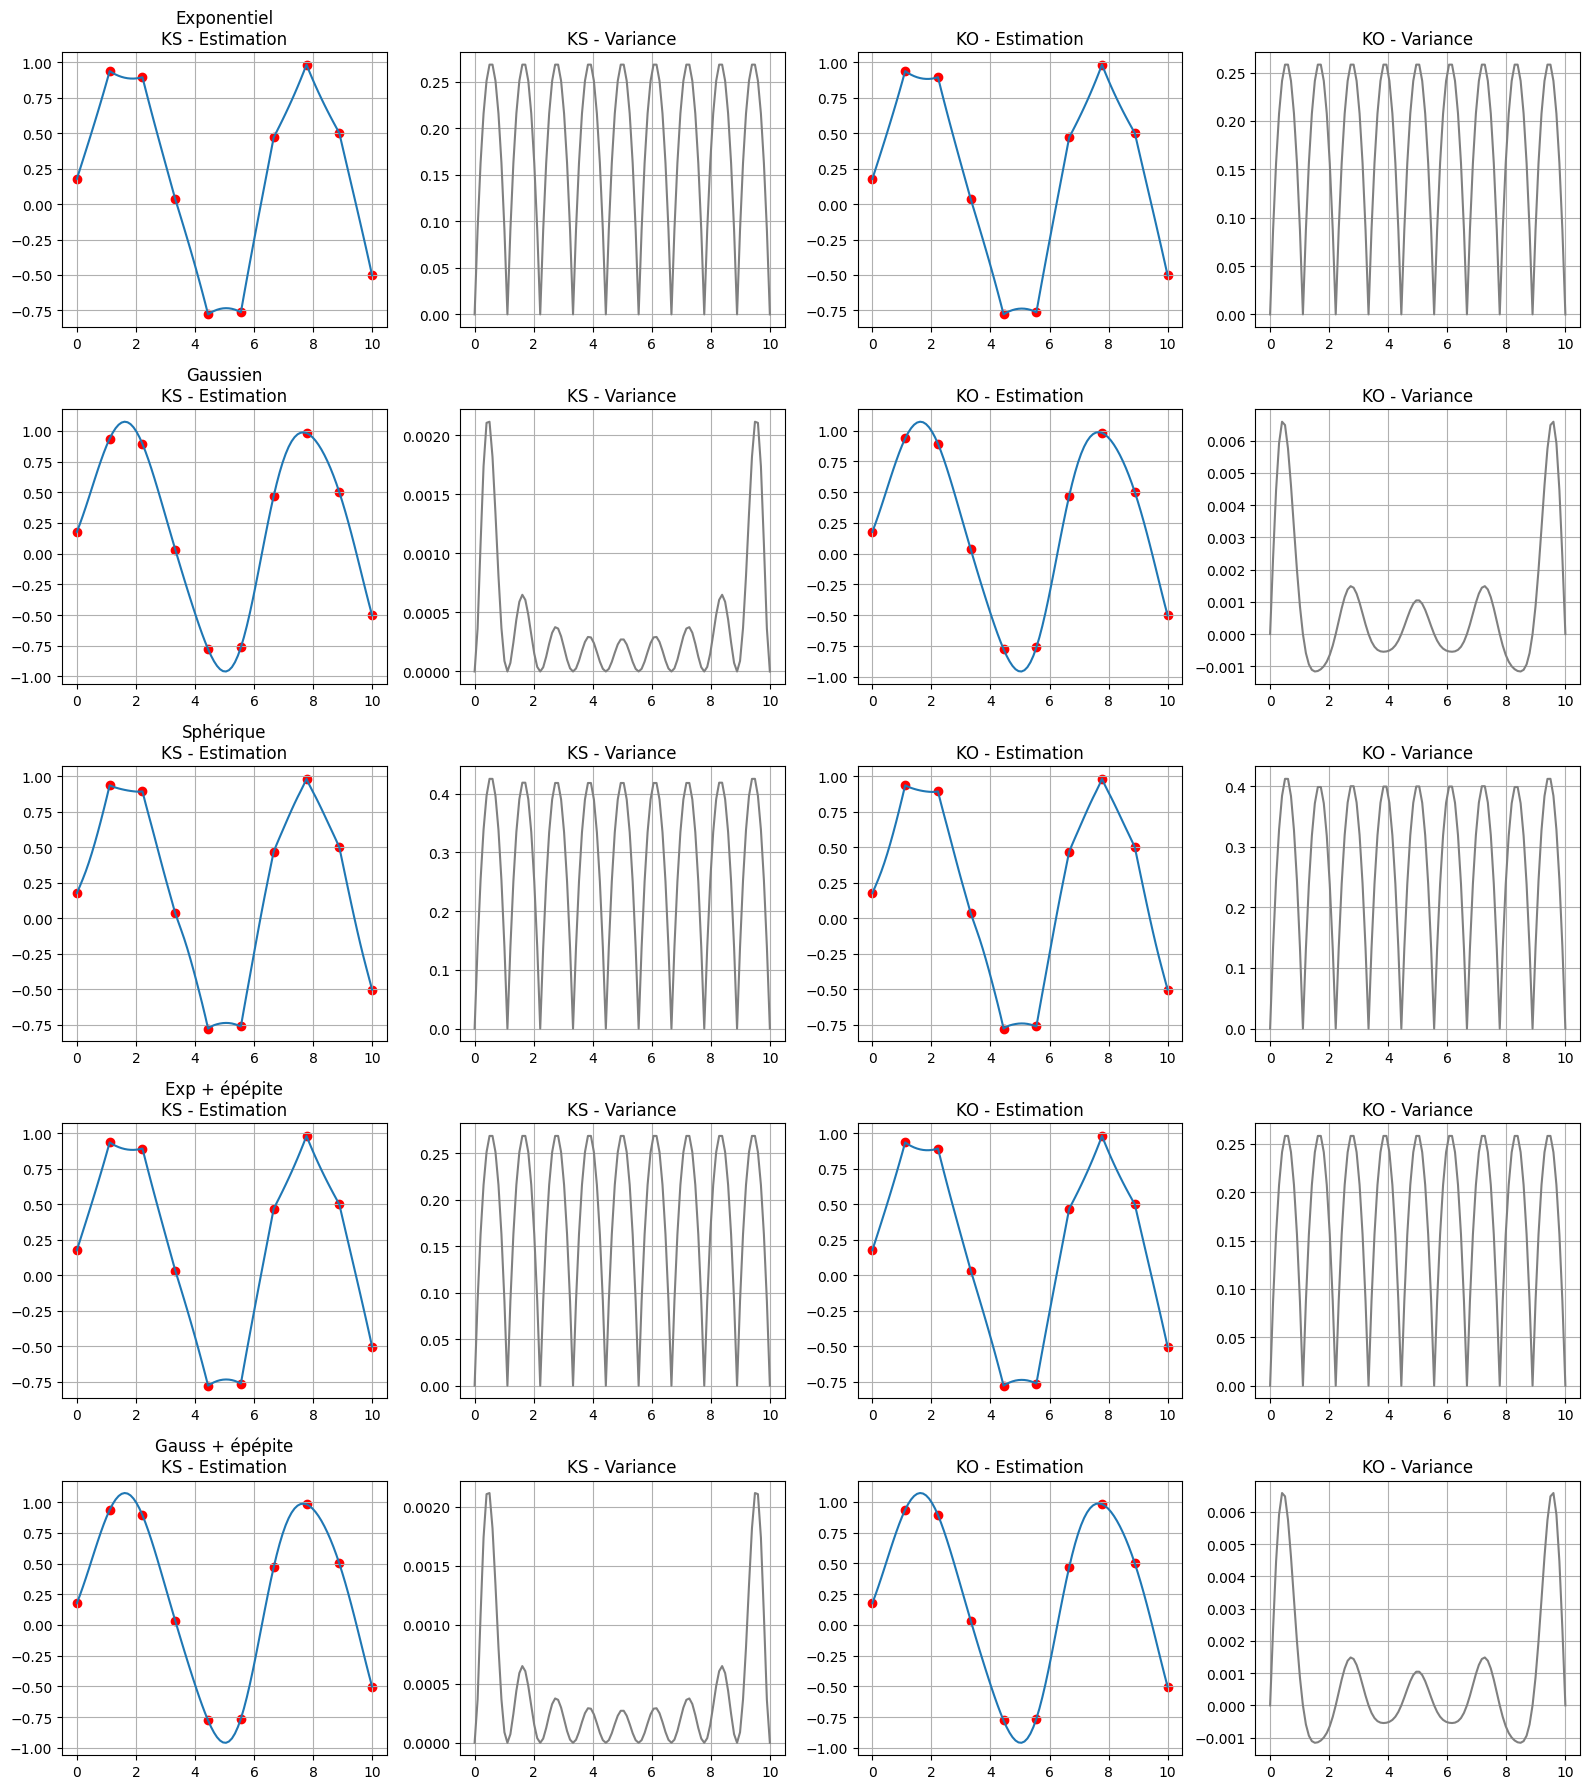

In [6]:
# Atelier : Comparaison de 5 modèles de variogramme en 1D pour KS et KO

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

np.random.seed(0)

# -----------------------------
# 1. Données 1D synthétiques
# -----------------------------
x_samples = np.linspace(0, 10, 10)
z_samples = np.sin(x_samples) + np.random.normal(0, 0.1, len(x_samples))

x_grid = np.linspace(0, 10, 100)

# -----------------------------
# 2. Modèles de variogramme
# -----------------------------
def variogram_model(h, model="exp", range_=2.0, sill=1.0, nugget=0.0):
    h = np.abs(h)
    if model == "exp":
        return nugget + (sill - nugget) * (1 - np.exp(-h / range_))
    elif model == "gauss":
        return nugget + (sill - nugget) * (1 - np.exp(-(h / range_)**2))
    elif model == "sph":
        return np.where(h <= range_, nugget + (sill - nugget)*(1.5*h/range_ - 0.5*(h/range_)**3), sill)
    else:
        return np.full_like(h, np.nan)

# -----------------------------
# 3. Krigeage simple et ordinaire en 1D
# -----------------------------
def krige_1d(x_grid, x_samples, z_samples, model, kind="simple"):
    n = len(x_samples)
    m = len(x_grid)
    Z_krig = np.zeros(m)
    Var_krig = np.zeros(m)

    d_matrix = np.abs(x_samples[:, None] - x_samples[None, :])
    C = 1 - variogram_model(d_matrix, model)

    for i, x0 in enumerate(x_grid):
        d = np.abs(x_samples - x0)
        c0 = 1 - variogram_model(d, model)

        if kind == "simple":
            try:
                w = np.linalg.solve(C, c0)
                Z_krig[i] = np.mean(z_samples) + w @ (z_samples - np.mean(z_samples))
                Var_krig[i] = 1 - w @ c0
            except:
                Z_krig[i] = np.nan
                Var_krig[i] = np.nan
        elif kind == "ordinary":
            C_ext = np.ones((n+1, n+1))
            C_ext[:n, :n] = C
            C_ext[-1, -1] = 0
            c0_ext = np.ones(n+1)
            c0_ext[:n] = c0
            try:
                w_ext = np.linalg.solve(C_ext, c0_ext)
                Z_krig[i] = w_ext[:n] @ z_samples
                Var_krig[i] = 1 - w_ext[:n] @ c0
            except:
                Z_krig[i] = np.nan
                Var_krig[i] = np.nan
    return Z_krig, Var_krig

# -----------------------------
# 4. Affichage : 5 variogrammes x (KS + KO)
# -----------------------------
models = ["exp", "gauss", "sph", "exp_nug", "gauss_nug"]
labels = ["Exponentiel", "Gaussien", "Sphérique", "Exp + épépite", "Gauss + épépite"]

fig, axes = plt.subplots(5, 4, figsize=(16, 18))

for i, model in enumerate(models):
    model_base = model.replace("_nug", "")
    nugget = 0.3 if "nug" in model else 0.0
    label = labels[i]

    z_ks, var_ks = krige_1d(x_grid, x_samples, z_samples, model_base, kind="simple")
    z_ko, var_ko = krige_1d(x_grid, x_samples, z_samples, model_base, kind="ordinary")

    axes[i, 0].plot(x_grid, z_ks, label="KS")
    axes[i, 0].scatter(x_samples, z_samples, color='red')
    axes[i, 0].set_title(f"{label}\nKS - Estimation")

    axes[i, 1].plot(x_grid, var_ks, label="Var KS", color='gray')
    axes[i, 1].set_title("KS - Variance")

    axes[i, 2].plot(x_grid, z_ko, label="KO")
    axes[i, 2].scatter(x_samples, z_samples, color='red')
    axes[i, 2].set_title("KO - Estimation")

    axes[i, 3].plot(x_grid, var_ko, label="Var KO", color='gray')
    axes[i, 3].set_title("KO - Variance")

for ax in axes.ravel():
    ax.grid(True)

plt.tight_layout()
plt.show()
